In [1]:
%matplotlib widget
import torch
import numpy as np
import torch.optim as optim
from simple_pinn import SimplePINN
import matplotlib.pyplot as plt

In [2]:
model = SimplePINN(1, [20, 20, 20], 1)
print(model)

SimplePINN(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
  )
  (head): Linear(in_features=20, out_features=1, bias=True)
)


In [3]:
R = 1.0  # rate of maximum population growth parameterizing the equation
X_BOUNDARY = 0.0  # boundary condition coordinate
F_BOUNDARY = 0.5  # boundary condition value
DOMAIN = (-5.0, 5.0)  # x boundaries of the problem

analytical_sol_fn = lambda x: 1.0 / (1.0 + (1.0 / F_BOUNDARY - 1.0) * np.exp(-R * x))

In [4]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 100
n_epochs = 1000

In [5]:
def compute_loss(x, y, model):
    dy_dx = torch.autograd.grad(
        y, x, grad_outputs=torch.ones_like(y), create_graph=True
    )[0]
    residual = dy_dx - R * y * (1.0 - y)
    residual_loss = torch.mean(torch.square(residual))
    boundary_value = model(torch.tensor([X_BOUNDARY]))
    boundary_loss = torch.mean(
        torch.square(boundary_value - torch.tensor([F_BOUNDARY]))
    )
    return residual_loss + boundary_loss

In [6]:
loss_history = []
for epoch in range(n_epochs):
    x = (
        torch.rand(batch_size, 1, requires_grad=True) * (DOMAIN[1] - DOMAIN[0])
        + DOMAIN[0]
    )
    y = model(x)
    loss = compute_loss(x, y, model)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1} | Loss: {loss.item():.6f}")
    loss_history.append(loss.item())

Epoch 1 | Loss: 0.243437
Epoch 101 | Loss: 0.034070
Epoch 201 | Loss: 0.000140
Epoch 301 | Loss: 0.000065
Epoch 401 | Loss: 0.000033
Epoch 501 | Loss: 0.000028
Epoch 601 | Loss: 0.000021
Epoch 701 | Loss: 0.000013
Epoch 801 | Loss: 0.000009
Epoch 901 | Loss: 0.000006


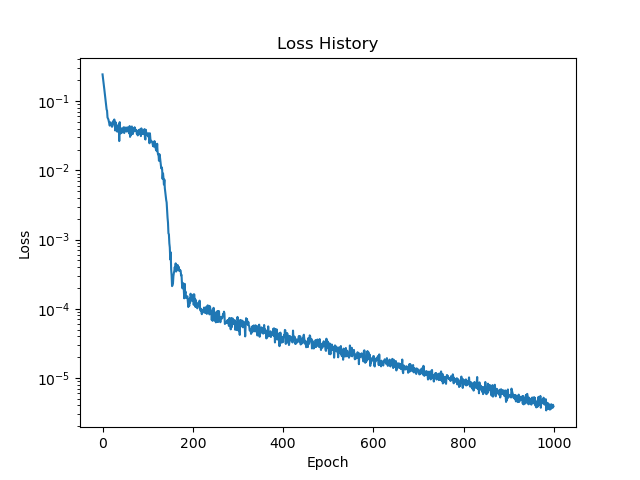

In [7]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss History")
plt.semilogy()
plt.show()

In [8]:
x_eval = torch.linspace(DOMAIN[0], DOMAIN[1], steps=101).reshape(-1, 1)
y_eval = model(x_eval)
y_true = analytical_sol_fn(x_eval.detach().numpy())

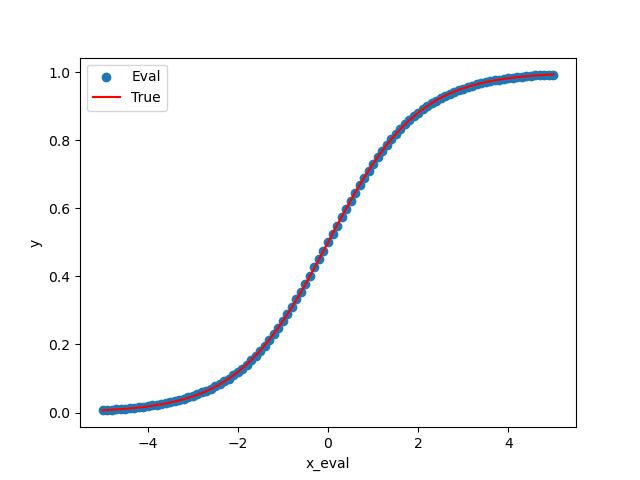

In [9]:
plt.figure()
plt.scatter(x_eval, y_eval.detach().numpy(), label="Eval", marker="o")
plt.plot(x_eval, y_true, label="True", color="red")
plt.xlabel("x_eval")
plt.ylabel("y")
plt.legend(loc="best")
plt.show()